In [24]:
import re
import collections
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk


In [25]:
df = pd.read_csv('../datasets/raw/2020_06_23_CE-BVerwG_DE_Datensatz.csv')


In [26]:

def create_datasets(df, split=0.7, n=3):
    assert(0 < split < 1)
    assert(n >= 2)
    total_num_documents = 300
    data = []
    for judgement in df['text'][:total_num_documents]:
        data.extend(judgement.lower().replace("\n", " ").split(" "))
    vocab = nltk.lm.Vocabulary(data, unk_cutoff=3)
    
    filtered_data = [word for word in data if word in vocab and len(word) > 1]
    print(len(filtered_data), len(data))

    # split to train and test
    split_index = round(len(filtered_data) * split)
    traindata = filtered_data[:split_index]
    testdata = filtered_data[split_index:]
    
    # create ngrams
    traindata = nltk.ngrams(traindata, n)
    testdata = " ".join(testdata)
    # testdata = nltk.ngrams(testdata, n)
    return list(traindata), testdata, vocab

In [27]:
n = 3
traindata, testdata, vocab = create_datasets(df, split=0.8, n=n)
traindata = [("<UNK>",)] + traindata
model = nltk.lm.MLE(n)
model.fit([traindata], vocabulary_text=vocab)

162949 206947


In [28]:
def evaluate_model(model, testdata, prediction_length, print_correct_samples=False):
    testdata_tuples = testdata.split(" ")
    counter = 0
    score = 0
    for i in tqdm(range(n,len(testdata_tuples)-prediction_length, prediction_length)):
        context = testdata_tuples[i-n:i]
        target = testdata_tuples[i:i + prediction_length]
        prediction = model.generate(prediction_length, text_seed=context)
        
        # needed as it only outputs a list if num_words>1
        if prediction_length == 1:
            prediction = [prediction]

        # check if all predictions for this tuple were correct
        correct = all([pred_word == target_word for (pred_word, target_word) in zip(prediction, target)])
        if correct: 
            score += 1
            if print_correct_samples:
                print(context, "->", prediction, "target: ", target[0])
        counter += 1

    print(score, "/", counter, "correct")
    return score/counter

In [29]:
def check_model(data, model, searchstr="gemäß §"):
    fail_count = 0
    counter = 0
    occurences = [m.start() for m in re.finditer(searchstr, data)]
    for occ in occurences:
        start_offset = len(searchstr)
        context = data[occ-30:occ + start_offset]
        target = data[occ + start_offset:occ + start_offset + 30]
        print(context)
        print(target)
        print()
        counter += 1
        words = model.generate(3, text_seed=context)
        if '<UNK>' not in words:
            print("context:", context)
            print("target", target)
            print(" -> ", words)
        else:
            fail_count += 1
    print("fails: ", fail_count, "/", counter)


In [30]:
def fit_ngram(df, n):
    """ formats train dataset for n-gram and trains model"""
    traindata, testdata, vocab = create_datasets(df, split=0.8, n=n)
    traindata = [("<UNK>",)] + traindata
    model = nltk.lm.MLE(n)
    model.fit([traindata], vocabulary_text=vocab)
    return model

In [31]:
def compute_scores() -> dict:
    """ computes percentage of succeses for a range of n and num_predictions.
    n stands for the n-gram order. num_predictions for the number of words to predict
    """
    n_range = range(2,5)
    scores = {str(n) : [0 for i in range(4)] for n in n_range}
    print(scores)
    for n in n_range:
        model = fit_ngram(df, n)
        for num_predictions in range(1,4):
            scores[str(n)][num_predictions] = evaluate_model(model, testdata, num_predictions)
    return scores

In [32]:
scores = compute_scores()

{'2': [0, 0, 0, 0], '3': [0, 0, 0, 0], '4': [0, 0, 0, 0]}
162949 206947


  0%|          | 39/16293 [00:00<00:42, 385.67it/s]

4213 / 32586 correct


  0%|          | 36/10862 [00:00<00:30, 350.59it/s]

349 / 16293 correct


100%|██████████| 10862/10862 [00:31<00:00, 344.32it/s]


40 / 10862 correct
162949 206947


  7%|▋         | 1077/16293 [00:00<00:02, 5127.10it/s]

7366 / 32586 correct


  8%|▊         | 841/10862 [00:00<00:02, 4183.56it/s]

1810 / 16293 correct


100%|██████████| 10862/10862 [00:02<00:00, 3641.76it/s]


693 / 10862 correct
162949 206947


  9%|▉         | 1496/16293 [00:00<00:01, 7461.87it/s]

7328 / 32586 correct


  6%|▌         | 663/10862 [00:00<00:01, 6628.50it/s]

2489 / 16293 correct


100%|██████████| 10862/10862 [00:01<00:00, 6119.61it/s]

1147 / 10862 correct


In [47]:
def plot_scores(scores):
    fig = plt.figure()

    plt.title("Accuracies of ngram models over testset")
    plt.ylabel("success rate")
    plt.xlabel("length of prediction in words")

    for ngram in scores.keys():
        
        plt.plot([i for i in range(1,5)], scores[ngram], label="ngram-order: "+str(ngram))
    plt.legend()

    plt.show()
    

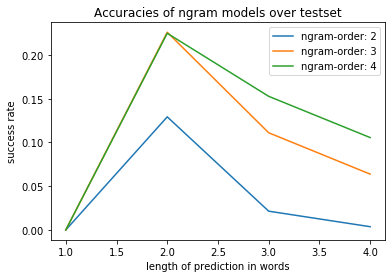

In [48]:
plot_scores(scores)